Day 7 - Ornstein-Uhlenbeck process (simple continuous time model for the mean reversion). Good model for interest rates.

Running OU simulation


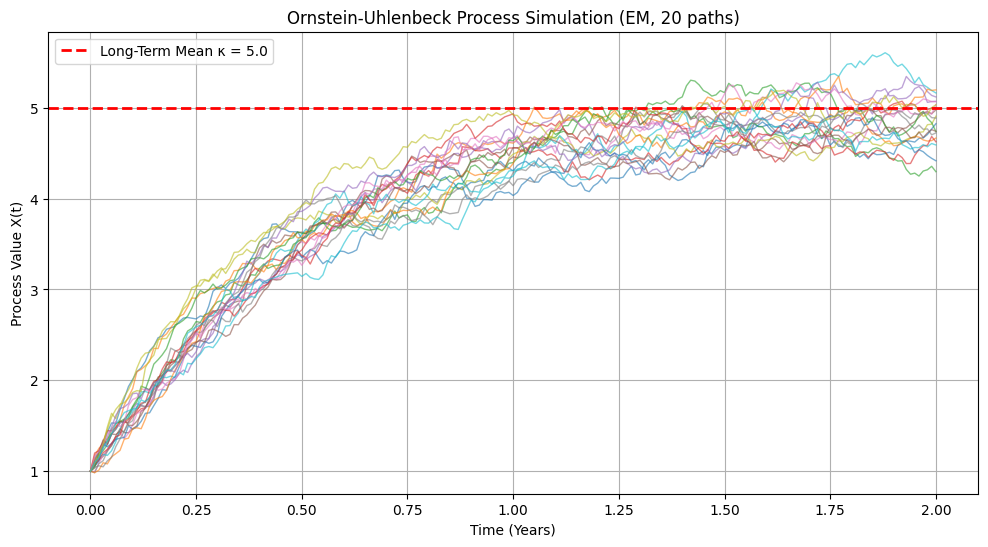

Analytical E[X(T)]   = 4.9267
Analytical StdDev[X(T)] = 0.2500
Simulated Mean X(T)    = 4.9342
Simulated StdDev X(T)  = 0.2508


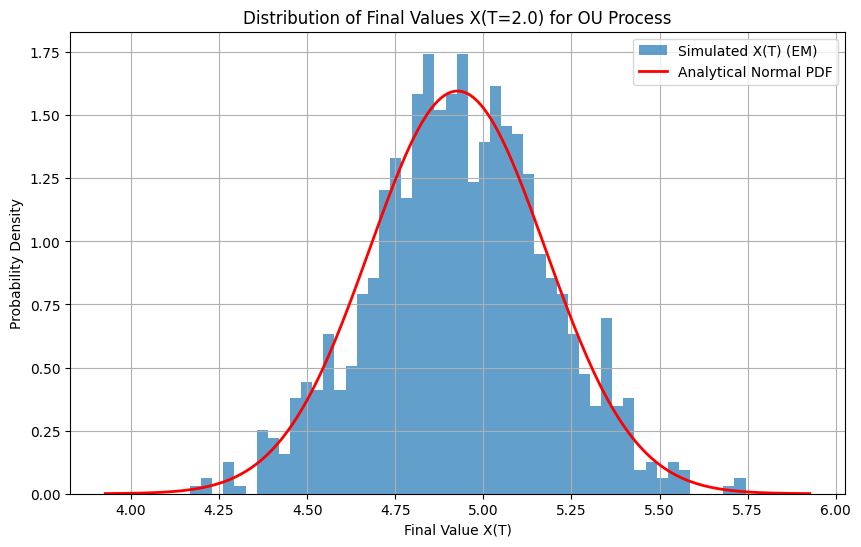


--- Starting Strong Convergence Analysis for OU (EM) ---
Using 5000 paths.
Running Conv. Check: Coarse dt=0.25000 (8 steps), Fine dt=0.06250 (32 steps)
Running Conv. Check: Coarse dt=0.12500 (16 steps), Fine dt=0.03125 (64 steps)
Running Conv. Check: Coarse dt=0.06250 (32 steps), Fine dt=0.01562 (128 steps)
Running Conv. Check: Coarse dt=0.03125 (64 steps), Fine dt=0.00781 (256 steps)
Running Conv. Check: Coarse dt=0.01562 (128 steps), Fine dt=0.00391 (512 steps)


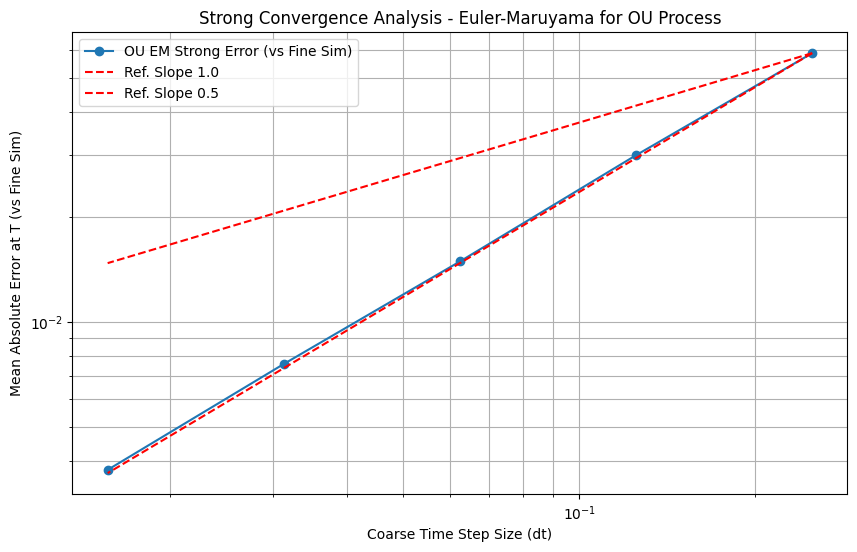

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import sys, os
import time

notebook_dir = os.path.dirname(os.path.abspath("__file__")) 
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

from sde_simulator.simulators import simulate_ou_em_vectorized

#imports above


X0 = 1.0         #initial value
THETA = 2.0      #speed of reversion (moderate)
KAPPA = 5.0      #long-term mean
SIGMA = 0.5      #volatility
T = 2.0          #time horizon (2 years to see reversion)
DT = 0.01        #time step
NUM_PATHS = 1000 #number of paths for distribution check

print("Running OU simulation")
t_ou, X_ou_paths = simulate_ou_em_vectorized(X0, THETA, KAPPA, SIGMA, T, DT, NUM_PATHS)

plt.figure(figsize=(12, 6))
#first 20 paths
num_paths_to_plot = min(20, NUM_PATHS) 
plt.plot(t_ou, X_ou_paths[:, :num_paths_to_plot], lw=1, alpha=0.6)
#highlight the mean level kappa
plt.axhline(KAPPA, color='red', linestyle='--', lw=2, label=f'Long-Term Mean κ = {KAPPA}')
plt.title(f'Ornstein-Uhlenbeck Process Simulation (EM, {num_paths_to_plot} paths)')
plt.xlabel('Time (Years)')
plt.ylabel('Process Value X(t)')
plt.legend()
plt.grid(True)
plt.show()

#Compare Final Distribution to Analytical
X_T_sim = X_ou_paths[-1, :]

#analytical mean and variance calculation
mean_analytical = X0 * np.exp(-THETA * T) + KAPPA * (1 - np.exp(-THETA * T))
var_analytical = (SIGMA**2 / (2 * THETA)) * (1 - np.exp(-2 * THETA * T))
stdev_analytical = np.sqrt(var_analytical)

print(f"Analytical E[X(T)]   = {mean_analytical:.4f}")
print(f"Analytical StdDev[X(T)] = {stdev_analytical:.4f}")
print(f"Simulated Mean X(T)    = {np.mean(X_T_sim):.4f}")
print(f"Simulated StdDev X(T)  = {np.std(X_T_sim):.4f}")


#histogram and analytical PDF
plt.figure(figsize=(10, 6))
plt.hist(X_T_sim, bins=50, density=True, alpha=0.7, label='Simulated X(T) (EM)')

#generate points for PDF curve
x_min = min(mean_analytical - 4*stdev_analytical, X_T_sim.min())
x_max = max(mean_analytical + 4*stdev_analytical, X_T_sim.max())
x_values = np.linspace(x_min, x_max, 200)

#calculate analytical Normal PDF
pdf_analytical = norm.pdf(x_values, loc=mean_analytical, scale=stdev_analytical)

plt.plot(x_values, pdf_analytical, 'r-', lw=2, label='Analytical Normal PDF')
plt.title(f'Distribution of Final Values X(T={T}) for OU Process')
plt.xlabel('Final Value X(T)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()




#use a reasonable number of paths for convergence check
NUM_PATHS_CONV = 5000 #can adjust this

print(f"\n--- Starting Strong Convergence Analysis for OU (EM) ---")
print(f"Using {NUM_PATHS_CONV} paths.")

#refinement factor for reference solution
M = 4 

#range of COARSE steps 
n_steps_coarse_range = 2**np.arange(3, 8) #8, 16, 32, 64, 128

dt_values_ou_em = np.zeros(len(n_steps_coarse_range))
strong_errors_ou_em = np.zeros(len(n_steps_coarse_range))

#loop through different numbers of coarse steps
for i, n_steps_coarse in enumerate(n_steps_coarse_range):
    dt_coarse = T / n_steps_coarse
    dt_values_ou_em[i] = dt_coarse
    
    n_steps_fine = n_steps_coarse * M
    dt_fine = T / n_steps_fine
    
    print(f"Running Conv. Check: Coarse dt={dt_coarse:.5f} ({n_steps_coarse} steps), Fine dt={dt_fine:.5f} ({n_steps_fine} steps)")

    #1. generate fine-grained random numbers
    Z_fine = np.random.normal(0, 1, size=(n_steps_fine, NUM_PATHS_CONV))

    #2. simulate reference solution with fine steps
    _, X_fine = simulate_ou_em_vectorized(X0, THETA, KAPPA, SIGMA, T, dt_fine, NUM_PATHS_CONV, Z=Z_fine)
    X_T_ref = X_fine[-1, :]

    #3. aggregate random numbers for coarse steps
    Z_fine_reshaped = Z_fine.reshape(n_steps_coarse, M, NUM_PATHS_CONV)
    Z_coarse = np.sum(Z_fine_reshaped, axis=1) / np.sqrt(M) 
    
    #4. simulate coarse solution using aggregated random numbers
    _, X_coarse = simulate_ou_em_vectorized(X0, THETA, KAPPA, SIGMA, T, dt_coarse, NUM_PATHS_CONV, Z=Z_coarse)
    X_T_sim = X_coarse[-1, :]

    #5. calculate the mean absolute error
    strong_errors_ou_em[i] = np.mean(np.abs(X_T_sim - X_T_ref))

#plotting strong convergence for OU EM
plt.figure(figsize=(10, 6))
plt.plot(dt_values_ou_em, strong_errors_ou_em, 'o-', label='OU EM Strong Error (vs Fine Sim)')

#add reference line for slope 1.0
plt.plot(
    dt_values_ou_em, 
    strong_errors_ou_em[0] * (dt_values_ou_em / dt_values_ou_em[0])**1,
    'r--', 
    label='Ref. Slope 1.0'
)

#ref slope 0.5
plt.plot(
    dt_values_ou_em, 
    strong_errors_ou_em[0] * (dt_values_ou_em / dt_values_ou_em[0])**0.5,
    'r--', 
    label='Ref. Slope 0.5'
)

plt.title('Strong Convergence Analysis - Euler-Maruyama for OU Process')
plt.xlabel('Coarse Time Step Size (dt)')
plt.ylabel('Mean Absolute Error at T (vs Fine Sim)')
plt.xscale('log')
plt.yscale('log') 
plt.grid(True, which='both')
plt.legend()
plt.show()

It's not normal that the mean absolute error is close to the reference slope of 1, should be close to the 0.5 one.. So this result is quite unexpected, maybe we did a mistake? From the code it looks like it's not the case tho.
